In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import joblib
import pickle

In [19]:
### train data loading and preprocessing ###
## concatenating observations in the same group
data_dict = {} # separate data by .txt file

directory = 'IMU-train'

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    
    if filename.endswith('.txt'):
        data = np.loadtxt(filepath, delimiter='\t')  
                
        if filename[:5] == "beat3":
            key = "beat3"
        elif filename[:5] == "beat4":
            key = "beat4"
        elif filename[:6] == "circle":
            key = "circle"
        elif filename[:5] == "eight":
            key = "eight"
        elif filename[:3] == "inf":
            key = "inf"
        elif filename[:4] == "wave":
            key = "wave"

        if key in data_dict:
            data_dict[key] = np.concatenate((data_dict[key], data), axis=0)
        else:
            data_dict[key] = data

        # concatenate data
    else:
        raise Exception('non-.txt file in training folder')

print(data_dict.keys())

dict_keys(['wave', 'circle', 'eight', 'inf', 'beat4', 'beat3'])


In [20]:
### Plotting functions ######

def plot_training_curve(likelihood_list, motion, M, S):
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.plot(likelihood_list, marker='o', linestyle='-', color='blue') 
    plt.title(f'Training Curve of Likelihood Estimates of {motion} with {M} observation clusters and {S} hidden states')
    plt.xlabel('Epoch')
    plt.ylabel('Log-Likelihood Estimate')
    plt.grid(True)  # Show grid for better readability
    plt.savefig(f'IMU-train-visuals/TrainingCurves/training_curve_{motion}_{M}clusters_{S}states.png')

In [21]:
#### Load Kmeans model
M = 80 # number of clusters, aka number of emission classes
kmeans_fn = f'kmeans_model_{M}.pkl'
kmeans_model = joblib.load(f'Kmeans-models/{kmeans_fn}')

In [22]:
### scaled forward calculation function
def scaled_forward(pi, A, B, O):
    """    
    A: Transition probabilities, shape(S, S), A_ij is prob from i to j
    B: Emission probabilities, shape(S, M)
    pi: Initial state probabilities, shape(S,)
    O: observation sequence, shape(T,)
    """
    
    # # Base case
    # alpha[0, :] = pi * B[:, observations[0]]

    # for t in range(len(O)):
    num_observations = len(O)
    num_states = A.shape[0]

    # print("pi: ", pi)
    # print(B[:, O[0]])
    # Initialize forward probabilities matrix
    alpha = np.zeros((num_observations, num_states), dtype=np.float64)
    # Initialize scaling factors
    c = np.zeros(num_observations, dtype=np.float64)
    
    # Base case with scaling
    # print("pi: ", pi)
    # print("B: ", B)
    # print("O[0]: ", O[0])
    # print("B[:, O[0]]: ", B[:, O[0]])
    alpha[0, :] = pi * B[:, O[0]] # make sure to multiply pi by B
    # alpha[0, :] = pi # NOTE: slides might be wrong here
    # print(alpha[0, :])
    c[0] = 1 / np.sum(alpha[0, :])
    alpha[0, :] *= c[0]
    # print("c[0]: ", c[0])
    # print(alpha[0, :])

    
    # print(alpha[0, :].shape)
    # Recursive step with scaling
    for t in range(1, num_observations):
        # slower version
        # for j in range(num_states):
        #     alpha[t, j] = np.dot(alpha[t-1, :], A[:, j]) * B[j, O[t]]

        # faster version w/ matmul
        new = (alpha[t-1, :].reshape(1, -1) @ A) * B[:, O[t]]
        # print("new shape: ", new.shape)
        # print("new: ", new)
        alpha[t, :] = new.flatten()

        # scaling
        c[t] = 1 / np.sum(alpha[t, :])
        # print("c shape:", c.shape)
        # print("c: ", c)
        alpha[t, :] *= c[t]
    
    # log probability of the observation sequence using scaling factors, for prediction and checking for convergence
    log_prob_observation = -np.sum(np.log(c))
    
    return alpha, c, log_prob_observation

### scaled forward calculation function
def scaled_backward(A, B, c, O):
    """    
    A: Transition probabilities, shape(S, S), A_ij is prob from i to j
    B: Emission probabilities, shape(S, M)
    c: scaling coefficients from forward
    O: observation sequence, shape(T,)
    """
    num_observations = len(O)
    num_states = A.shape[0]
    
    # TODO: figure out correct initialization
    beta = np.zeros((num_observations, num_states), dtype=np.float64)
    beta[num_observations-1, :] = c[num_observations-1] # NOTE: this might be incorrect, but i think correct
    # print("beta after base case: ", beta)

    # Recursive step with scaling
    for t in range(num_observations-2, -1, -1):
        # # slower version
        # for past in range(num_states):
        #     # TODO: check indexing on this
        #     beta[t, past] = np.sum(A[past, :] * B[:, O[t+1]] * beta[t+1, :])
        # beta[t, :] *= c[t]

        # faster version with matmul
        # NOTE: not sure on this reshaping
        Bs = (B[:, O[t+1]] * beta[t+1, :]).reshape(1, -1)
        # print("Bs.shape: ", Bs.shape)
        new = (Bs @ A.T) * c[t]
        # print("new shape: ", new.shape)
        # print("new: ", new)
        beta[t, :] = new.flatten()
    
    return beta

In [23]:
### E Step ####
def e_step(A, B, alpha, beta, O):
    """
    A: Transition probabilities, shape (S, S)
    B: Emission probabilities, shape (S, M)
    alpha: Forward probabilities, shape (T, S)
    beta: Backward probabilities, shape (T, S)
    O: Observation sequence, shape (T,)
    """
    S = A.shape[0]
    T = len(O)

    # Compute gamma
    ab = alpha * beta
    g_denom = np.sum(ab, axis=1, keepdims=True)
    # print("gamma denom: ", g_denom) # NOTE: do I need this denom?
    gamma = ab / g_denom # this could also probs be done with np.avg

    # compute xi
    xi = np.zeros((T-1, S, S))

    for t in range(T-1): # is there a way to get rid of this loop?
        # if t==0:
            # print("alpha[t, :, None] shape: ", alpha[t, :, None].shape)
            # print("beta[t+1, None, :] shape: ", beta[t+1, None, :].shape)
        xi_num = alpha[t, :, None] * A * B[:, O[t+1]] * beta[t+1, None, :]
        xi_denom = xi_num.sum()
        # print("xi denom: ", xi_denom)
        xi[t, :, :] = xi_num / xi_denom

    return gamma, xi

def e_step_scaled(A, B, alpha, beta, c, O):
    """
    A: Transition probabilities, shape (S, S)
    B: Emission probabilities, shape (S, M)
    alpha: Forward probabilities, shape (T, S)
    beta: Backward probabilities, shape (T, S)
    c: scaling coefficients from forward
    O: Observation sequence, shape (T,)
    """
    S = A.shape[0]
    T = len(O)

    # Compute gamma
    ab = alpha * beta
    g_denom = c.reshape(-1, 1) # divide numerator by scaling coefficient
    print("c.shape: ", c.shape)
    assert g_denom.shape == (T, 1)
    gamma = ab / g_denom

    # compute xi
    xi = np.zeros((T-1, S, S))

    for t in range(T-1): # is there a way to get rid of this loop?
        # if t==0:
            # print("alpha[t, :, None] shape: ", alpha[t, :, None].shape)
            # print("beta[t+1, None, :] shape: ", beta[t+1, None, :].shape)
        xi_num = alpha[t, :, None] * A * B[:, O[t+1]] * beta[t+1, None, :]
        xi[t, :, :] = xi_num

    return gamma, xi

In [24]:
### M-step ###

def m_step(gamma, xi, O, M):
    """
    gamma: State occupancy probabilities, shape (T, S)
    xi: ______ probabilities, shape (T-1, S, S)
    O: Observation sequence, shape (T,)
    M: Number of unique observation symbols
    """
    S = gamma.shape[1]  # Number of states
    # T = len(O)  # Length of observation sequence

    # Update transition matrix A
    # NOTE: FOR REPORT SUBMISSION, I transposed the previous denominator to make the broadcasting to recalculate A correct 
    A_denom = np.sum(gamma[:-1], axis=0, keepdims=True).T
    # print("A_denom.shape: ", A_denom.shape)
    assert A_denom.shape == (xi.shape[1], 1)
    # print("A_denom: ", A_denom)
    A = np.sum(xi, axis=0) / A_denom

    # Update emission matrix B
    B = np.zeros((S, M))
    for j in range(M):
        mask = (O == j)
        # print("gamma[mask]: ", gamma[mask])
        B[:, j] = np.sum(gamma[mask], axis=0) / np.sum(gamma, axis=0)

    return A, B

In [41]:
### General BM function

def baum_welch(O, S, M, max_epochs=30, tolerance=1e-6, plot_data=False, motion="INSERT MOTION", B_smoothing=True):
    """
    O: Observation sequence, shape (T,)
    S: Number of states in the HMM.
    M: Number of observation symbols/ kmeans clusters
    """
    likelihood_list = []
    # init transition_matrix A for left-to-right HMM
    # NOTE: for this matrix, the start matrix is the row index and the end matrix is the column index
    transition_matrix = np.zeros((S, S), dtype=np.float64)
    for i in range(S):
        transition_matrix[i, i] = 0.9
        if i == S - 1:
            # last state, allow transition back to the first state
            transition_matrix[i, 0] = 0.1
        else:
            transition_matrix[i, i + 1] = 0.1

    # make sure transition matrices rows add up to 1
    assert np.all(np.isclose(np.sum(transition_matrix, axis=1), 1))

    # initial state distribution pi
    init_st_distribution = np.zeros(S, dtype=np.float64)
    init_st_distribution[0] = 1.0

    # initial emission probabilities from each state
    emission_probs = np.ones((S, M), dtype=np.float64) / M

    prev_log_prob = -np.inf

    for epoch in range(max_epochs):
        print(f"\nEpoch ", epoch, "\n")

        ## Forward-Backward calculataions
        alpha, c, log_prob = scaled_forward(pi=init_st_distribution, A=transition_matrix, B=emission_probs, O=O)
        # print("alpha shape: ", alpha.shape)
        # print("c shape: ", c.shape)
        # print("c: ", c)
        # print("log_prob: ", log_prob)

        likelihood_list.append(log_prob)

        beta = scaled_backward(A=transition_matrix, B=emission_probs, c=c, O=O)
        # print("beta: ", beta)

        # Check for convergence
        if epoch > 0 and np.abs(log_prob - prev_log_prob) < tolerance:
            print(f"Converged at epoch {epoch}.")
            break
        prev_log_prob = log_prob

        ### E-Step
        print(f"\nE-step\n")
        # gamma, xi = e_step(A=transition_matrix, B=emission_probs, alpha=alpha, beta=beta, O=O)
        gamma, xi = e_step_scaled(A=transition_matrix, B=emission_probs, alpha=alpha, beta=beta, c=c, O=O)
        # print("gamma.shape: ", gamma.shape)
        # print("xi.shape: ", xi.shape)

        ### M-step
        print(f"\nM-step\n")
        transition_matrix, emission_probs = m_step(gamma=gamma, xi=xi, O=O, M=M)
        # print("transition_matrix.shape: ", transition_matrix.shape)
        # print("transition_matrix: ", transition_matrix)
        # print("emission_probs.shape: ", emission_probs.shape)

        # make sure transition matrices rows add up to 1
        # assert np.all(np.isclose(np.sum(transition_matrix, axis=1), 1))

    # plot training curve
    if plot_data:
        plot_training_curve(likelihood_list, motion, M, S)

    # add 1e-8 to emission probs to prevent trajectories with 0 probability
    if B_smoothing:
        emission_probs += 1e-8

    # return A, B, pi
    return transition_matrix, emission_probs, init_st_distribution

wave

Epoch  0 


E-step

c.shape:  (14530,)

M-step


Epoch  1 


E-step

c.shape:  (14530,)

M-step


Epoch  2 


E-step

c.shape:  (14530,)

M-step


Epoch  3 


E-step

c.shape:  (14530,)

M-step


Epoch  4 


E-step

c.shape:  (14530,)

M-step


Epoch  5 


E-step

c.shape:  (14530,)

M-step


Epoch  6 


E-step

c.shape:  (14530,)

M-step


Epoch  7 


E-step

c.shape:  (14530,)

M-step


Epoch  8 


E-step

c.shape:  (14530,)

M-step


Epoch  9 


E-step

c.shape:  (14530,)

M-step


Epoch  10 


E-step

c.shape:  (14530,)

M-step


Epoch  11 


E-step

c.shape:  (14530,)

M-step


Epoch  12 


E-step

c.shape:  (14530,)

M-step


Epoch  13 


E-step

c.shape:  (14530,)

M-step


Epoch  14 


E-step

c.shape:  (14530,)

M-step


Epoch  15 


E-step

c.shape:  (14530,)

M-step


Epoch  16 


E-step

c.shape:  (14530,)

M-step


Epoch  17 


E-step

c.shape:  (14530,)

M-step


Epoch  18 


E-step

c.shape:  (14530,)

M-step


Epoch  19 


E-step

c.shape:  (14530,)

M-step


Epoc

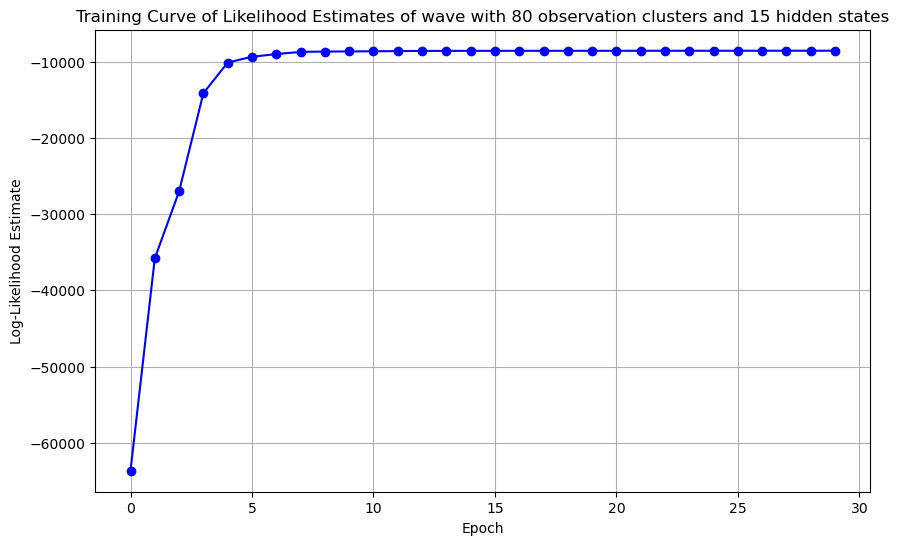

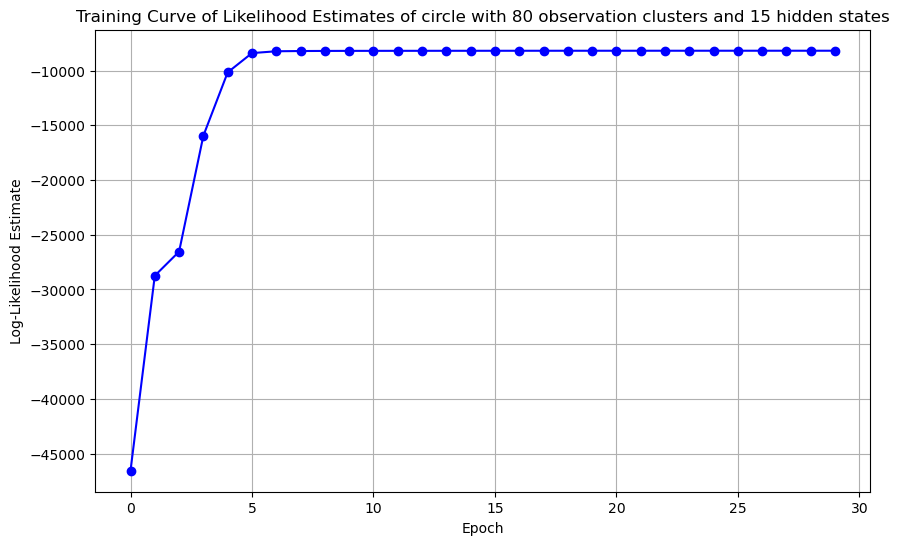

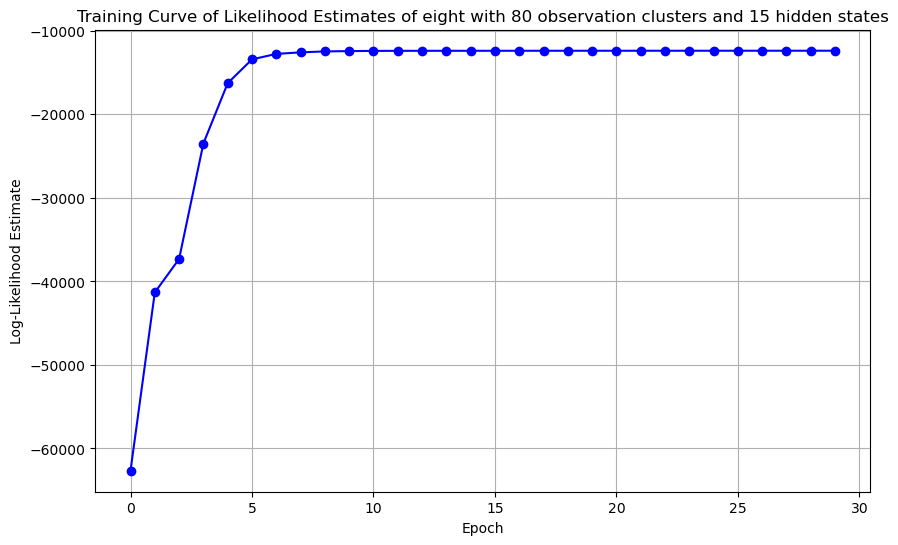

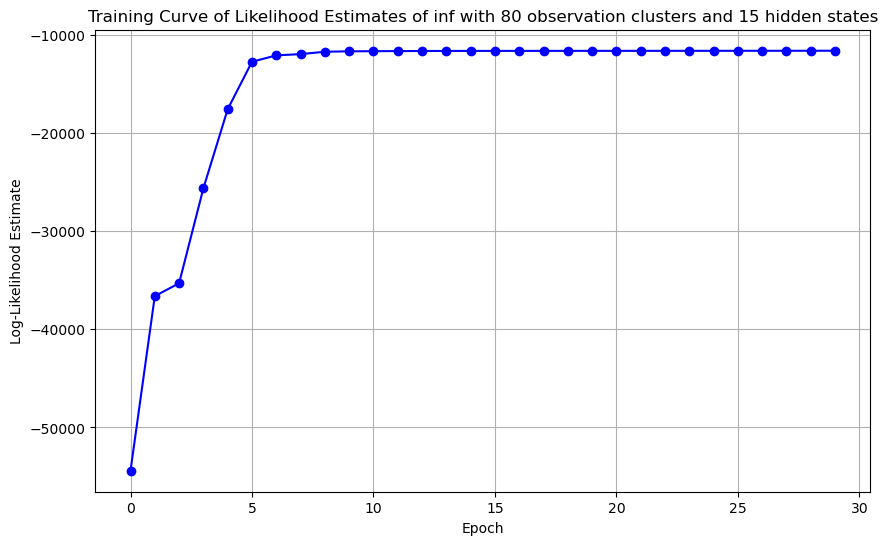

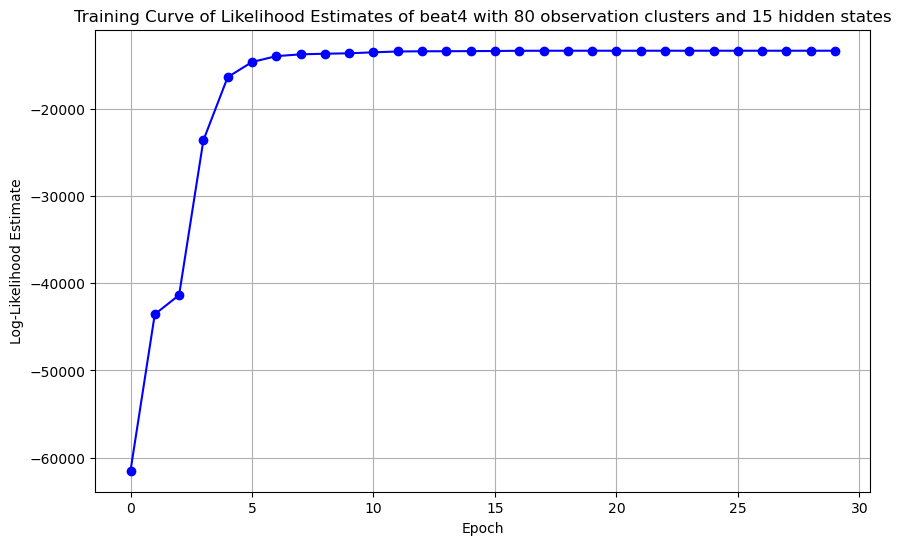

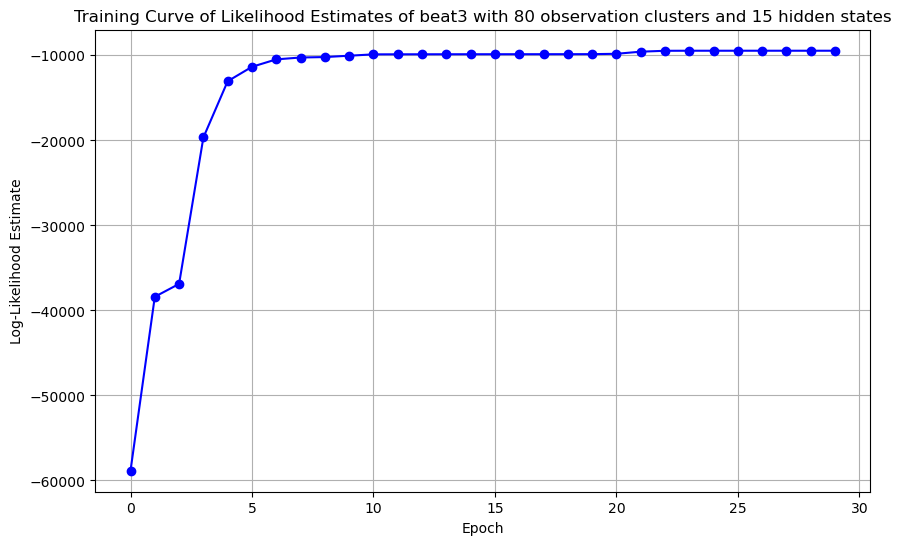

In [42]:
#### Apply BM function to training data
S = 15 # Number of Hidden States
tolerance = 1e-6
num_epochs = 30

models_dict = {}

for motion, data in data_dict.items():
    print(motion)
    # if motion == "wave":
    #     continue # here for now to skip wave
    ### get observations/emissions for data with kmeans model
    input_emissions = kmeans_model.predict(data[:, 1:])
    # print(input_emissions)
    
    # train HMM model
    transition_matrix, emission_probs, init_st_distribution = baum_welch(O=input_emissions, S=S, M=M, max_epochs=num_epochs, tolerance=tolerance, plot_data=True, motion=motion)

    # save the model to dictionary
    models_dict[motion] = (transition_matrix, emission_probs, init_st_distribution)
    # break # here for now to just test on one

print(models_dict.keys())
print("done!")

In [43]:
print(transition_matrix)
print(emission_probs)

[[0.98436335 0.01563665 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.91743757 0.08256243 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.86371538 0.13628462 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.93979873 0.06020127 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.84608137 0.15391863
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.93145726
  0.06854274 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.

Toy.shape:  (3000, 1)
Toy:  [0 0 0 ... 0 0 0]

Epoch  0 


E-step

c.shape:  (3000,)

M-step


Epoch  1 


E-step

c.shape:  (3000,)

M-step


Epoch  2 


E-step

c.shape:  (3000,)

M-step


Epoch  3 


E-step

c.shape:  (3000,)

M-step


Epoch  4 


E-step

c.shape:  (3000,)

M-step


Epoch  5 


E-step

c.shape:  (3000,)

M-step


Epoch  6 


E-step

c.shape:  (3000,)

M-step


Epoch  7 


E-step

c.shape:  (3000,)

M-step


Epoch  8 


E-step

c.shape:  (3000,)

M-step


Epoch  9 


E-step

c.shape:  (3000,)

M-step


Epoch  10 


E-step

c.shape:  (3000,)

M-step


Epoch  11 


E-step

c.shape:  (3000,)

M-step


Epoch  12 

Converged at epoch 12.
TOY transition_matrix, emission_probs, init_st_distribution:
[[9.99494518e-01 5.05482164e-04]
 [1.00696035e-03 9.98993040e-01]]
[[1.00000001e+00 1.00000189e-08]
 [5.02981903e-01 4.97018117e-01]]
[1. 0.]
done with toy training!


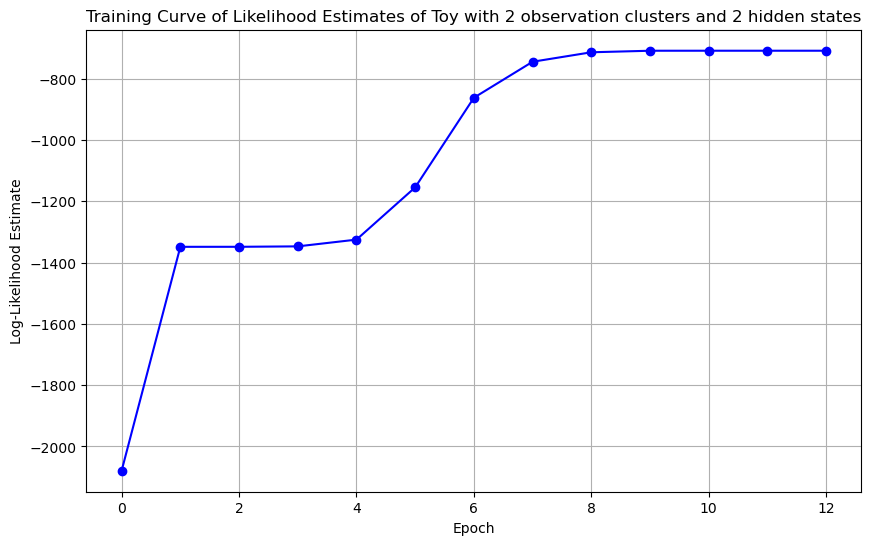

In [12]:
# #### Apply BM function to TOY data
# S = 2 # Number of Hidden States
# tolerance = 1e-6
# num_epochs = 30

# ### get observations/emissions for data with kmeans model

# Toy=np.concatenate((np.zeros((1000,1)),np.random.randint(0,2,size=(1000,1)),np.zeros((1000,1)))).astype(int)
# print("Toy.shape: ", Toy.shape)
# Toy=Toy.flatten()
# print("Toy: ", Toy)

# transition_matrix, emission_probs, init_st_distribution = baum_welch(O=Toy, S=S, M=2, max_epochs=num_epochs, tolerance=tolerance, plot_data=True, motion="Toy")

# # save the model to dictionary
# print('TOY transition_matrix, emission_probs, init_st_distribution:')
# for x in (transition_matrix, emission_probs, init_st_distribution):
#     print(f'{x}')

# assert np.all(np.isclose(np.sum(transition_matrix, axis=1), 1))

# print("done with toy training!")

In [28]:
#### log-likelihood for prediction #####
def predict_log_likelihood(A, B, pi, O):
    """
    Predict log-likelihood for scaled forward pass using trick on page 273 of Rabiner
    """
    # Run the forward algorithm with scaling
    _, _, log_likelihood = scaled_forward(A=A, B=B, pi=pi, O=O)
    
    return log_likelihood

In [37]:
## load val data
val_emissions = {} # separate data by .txt file

val_directory = 'IMU-train-additional'

for filename in os.listdir(val_directory):
    filepath = os.path.join(val_directory, filename)
    
    if filename.endswith('.txt'):
        data = np.loadtxt(filepath, delimiter='\t')  
                
        print(filename + ':')
        # print(data.shape)
        emissions = kmeans_model.predict(data[:, 1:])
        print(emissions.shape)
        val_emissions[filename] = emissions
        assert np.max(emissions) < M
    else:
        raise Exception('non-.txt file in training folder')    

circle31.txt:
(628,)
beat3_31.txt:
(749,)
inf31.txt:
(852,)
beat4_31.txt:
(845,)
eight31.txt:
(596,)
wave31.txt:
(441,)


In [13]:
print(models_dict)

{'wave': (array([[9.58886576e-01, 8.01989724e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.98323698e-01, 6.76697337e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.32330273e-01, 7.86459701e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.21354030e-01,
        9.99652855e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.0

In [38]:
predictions_dict = {}

#### make predictions on additional train data (val data) ####
for filename, emissions in val_emissions.items():
    # Evaluate the model
    predictions = [(model_name, predict_log_likelihood(A=model[0],B=model[1], pi=model[2], O=emissions)) for model_name, model in models_dict.items()]
    predictions = [(model_name, float('-inf') if np.isnan(ll) else ll) for model_name, ll in predictions]
    predictions.sort(key= lambda x: -x[1])

    print(f"Sorted predictions for {filename}: \n{predictions}")
    # store top 3 predicitons
    predictions_dict[filename] = predictions[:3]

Sorted predictions for circle31.txt: 
[('circle', -492.0854941530494), ('beat4', -4541.113197151281), ('beat3', -5515.569279716513), ('inf', -11568.187507202085), ('wave', -11568.187507202088), ('eight', -11568.187507202088)]
Sorted predictions for beat3_31.txt: 
[('beat3', -606.3458613329218), ('beat4', -749.4198940611778), ('wave', -6948.532138797362), ('circle', -12224.001771098807), ('inf', -12543.588508658653), ('eight', -13090.723891102076)]
Sorted predictions for inf31.txt: 
[('inf', -674.3809911869903), ('eight', -6578.766418188639), ('beat4', -10316.865061603079), ('beat3', -10426.964596740576), ('wave', -10918.837646670669), ('circle', -15694.41999384742)]
Sorted predictions for beat4_31.txt: 
[('beat4', -660.6063654736398), ('beat3', -1150.9566931177183), ('wave', -7558.84962996188), ('inf', -8384.891277453708), ('circle', -13780.390386313322), ('eight', -14842.1766134205)]
Sorted predictions for eight31.txt: 
[('eight', -634.2109922524515), ('inf', -4702.771793949033), ('be

In [39]:
for pair in predictions_dict.items():
    print(pair)

('circle31.txt', [('circle', -492.0854941530494), ('beat4', -4541.113197151281), ('beat3', -5515.569279716513)])
('beat3_31.txt', [('beat3', -606.3458613329218), ('beat4', -749.4198940611778), ('wave', -6948.532138797362)])
('inf31.txt', [('inf', -674.3809911869903), ('eight', -6578.766418188639), ('beat4', -10316.865061603079)])
('beat4_31.txt', [('beat4', -660.6063654736398), ('beat3', -1150.9566931177183), ('wave', -7558.84962996188)])
('eight31.txt', [('eight', -634.2109922524515), ('inf', -4702.771793949033), ('beat3', -7636.204668179613)])
('wave31.txt', [('wave', -1771.3947647917867), ('beat3', -3654.1284706787246), ('inf', -3971.696049389216)])


In [16]:
### save model params ####

kmeans_clusters = [M]
state_sizes = [S]
print(M)
print(S)
for M in kmeans_clusters:
    for S in state_sizes:
        with open(f'HMM-models/model_{M}clusters_{S}states.pkl', 'wb') as f:
        # with open(f'HMM-models/test_models.pkl', 'wb') as f:
            pickle.dump(models_dict, f)

80
15
